In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from scipy.stats.mstats import gmean
from sklearn.neighbors import KNeighborsClassifier

In [10]:

def print_partial_result(image):
    plt.figure()
    io.imshow(image)
    plt.show()

def list_image(dir_path="images/", manual_path="manual1/",mask_path="mask/"):
    image_list = []
    image_list.append("01_g")
    image_list.append("01_h")
    image_list.append("02_g")
    image_list.append("02_h")
    image_list.append("03_h")
    image_list.append("04_h")
    image_list.append("04_g")
    image_paths =  [[os.path.join(dir_path, file+".jpg"), os.path.join(manual_path, file+".tif"),os.path.join(mask_path, file+"_mask.tif")] for file in image_list]
    return [[cv2.imread(image_path[0], cv2.IMREAD_COLOR), cv2.imread(image_path[1], cv2.IMREAD_COLOR),cv2.imread(image_path[2], cv2.IMREAD_COLOR)]for image_path in image_paths]

def morphology(image, radius):
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN,
                          cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)), iterations=1)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)),
 iterations=1)

def prepare_image(image):
    b, image, r = cv2.split(image)
#     print_partial_result(image)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    prepared_image = clahe.apply(image)
    background = morphology(prepared_image, 5)
    background = morphology(background, 15)
    background = morphology(background, 25)
    prepared_image = cv2.subtract(background, prepared_image)
    prepared_image = clahe.apply(prepared_image)
#     print_partial_result(prepared_image)

    _, transformed_image = cv2.threshold(prepared_image, 15, 255, cv2.THRESH_BINARY)
    mask = np.ones(prepared_image.shape[:2], dtype="uint8") * 255
    contours, _ = cv2.findContours(transformed_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    prepared_image = cv2.bitwise_and(prepared_image, mask)
    _, prepared_image = cv2.threshold(prepared_image, 15, 255, cv2.THRESH_BINARY)
    return prepared_image

In [11]:
def show_statistic(prepared_image, manual, mask):
    in_scope = 0
    TP = 0
    FN = 0
    FP = 0
    TN = 0

    for i in range(len(prepared_image)):
        for j in range(len(prepared_image[0])):
            if mask[i,j,1] == 255:
                in_scope +=1
                if  manual[i,j,1] == 255:
                    if prepared_image[i,j] == 255:
                        TP +=1
                    else:
                        FN +=1
                else:
                    if prepared_image[i,j] == 0:
                        TN +=1
                    else:
                        FP +=1

    accuracy = (TP + TN)/(TP + TN + FP + FN)
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    mean_geometric = gmean([specificity,sensitivity])
    print("confusion matrix:")
    print(TP,",", FP)
    print(FN,",",TN)
    print("accuracy:", accuracy)
    print("sensitivity:", sensitivity)
    print("specificity:", specificity)
    print("geometric mean of sensitivity and specificity", mean_geometric)
    pass

In [12]:
def process_image_for_knn(image):
    processed = []
    for i in range(len(image)):
        left =2
        right = 2
        if i<=2:
            left = i
        if i >= len(image)-2:
            right = len(image)-i 
        for j in  range(len(image[0])):
            up = 2 
            down = 2
            if j<=2:
                up = j
            if j>= len(image[0])-2:
                down = len(image[0])-j

            fragment = image[i-left:i+right,j-up:j+down,:]
            _, g, _ = cv2.split(fragment)
            # moments = cv2.moments(g)
            Humoments = cv2.HuMoments( cv2.moments(g)).flatten()

            # try:
            processed.append(Humoments)
            del fragment
            del g
            # except:
                # print("error on indices:", i,j)
                # break
    return processed

def process_knn(image,knn,manual,mask):
    print("Processing knn...")
    rows,cols,_ = manual.shape
    X_test = process_image_for_knn(image)
    y_pred = []
    y_pred = knn.predict(X_test)
    prepared_image = y_pred.reshape((rows, cols))
    show_statistic(prepared_image, manual, mask)
    b, g, r = cv2.split(image)
    new_image=image.copy()
    new_image[:,:,2] = cv2.add(b,prepared_image)
    new_image[:,:,0] = cv2.add(r,prepared_image)
    new_image[:,:,1] = cv2.add(g,prepared_image)

    return prepared_image,new_image

def prepare_test(image,manual,knn):
    X_train= process_image_for_knn(image)
    b, manual, r = cv2.split(manual)
    y_train = manual.flatten()
    knn.fit(X_train, y_train)
    pass

def test_knn(image, manual):
    X_test = process_image_for_knn(image)
    b, manual, r = cv2.split(manual)
    y_test = manual.flatten()
    print("Hold out accuracy: ",knn.score(X_test, y_test))
    pass

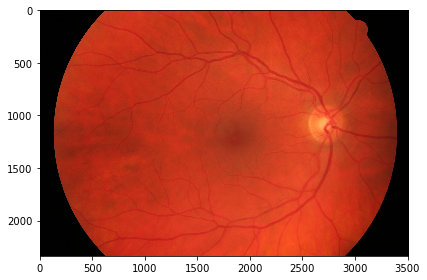

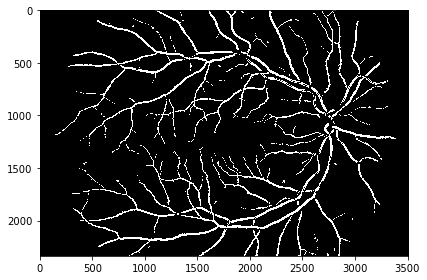

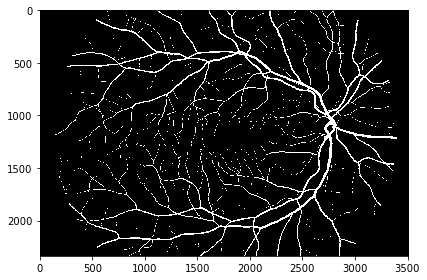

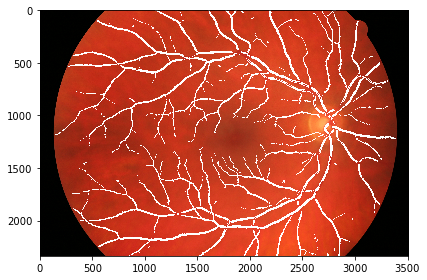

confusion matrix:
412435 , 134929
245748 , 6121291
accuracy: 0.9449443429895539
sensitivity: 0.7534931051366184
specificity: 0.9614030949080098
geometric mean of sensitivity and specificity 0.8511231422480482


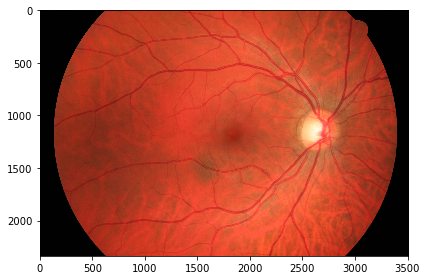

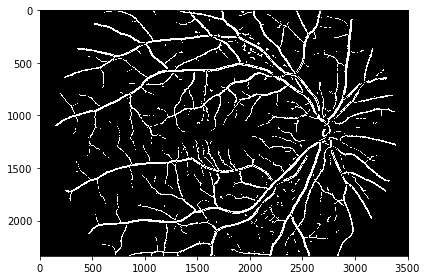

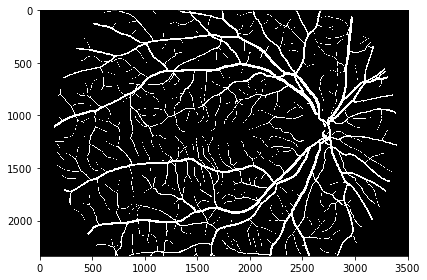

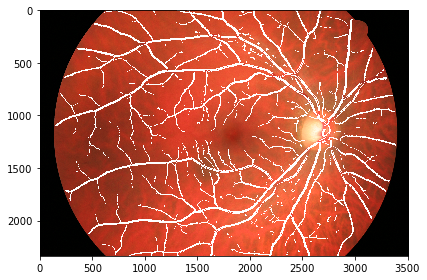

confusion matrix:
622440 , 211448
162458 , 5917437
accuracy: 0.9459187538862588
sensitivity: 0.7464311754096473
specificity: 0.9732794727540525
geometric mean of sensitivity and specificity 0.8523415634884228


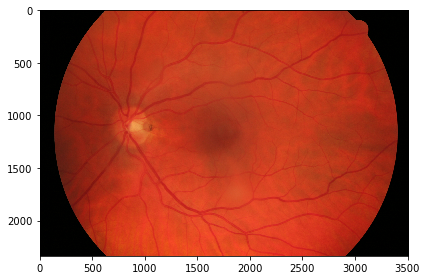

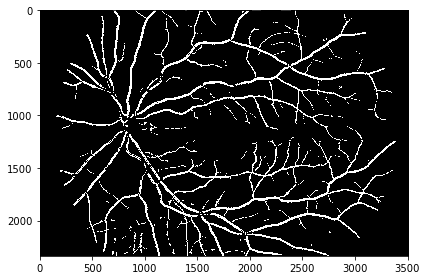

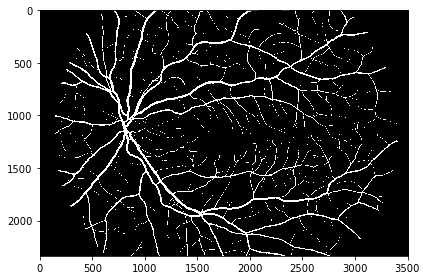

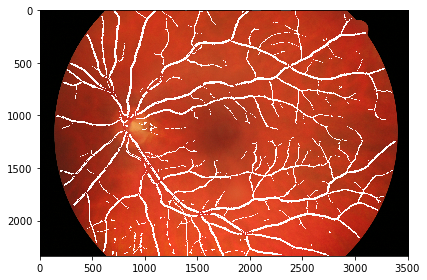

confusion matrix:
470501 , 139032
243274 , 6062923
accuracy: 0.9447193571755982
sensitivity: 0.7719040642590311
specificity: 0.9614230256365286
geometric mean of sensitivity and specificity 0.8614675507301776


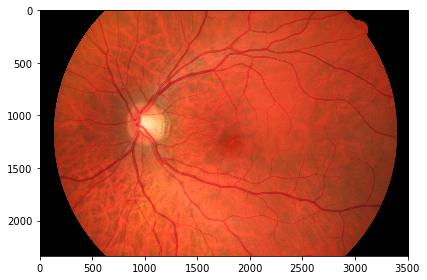

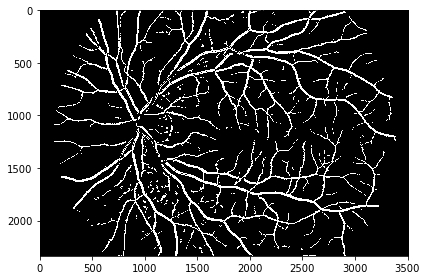

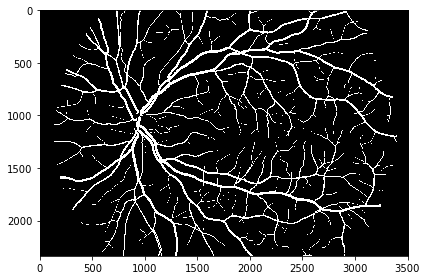

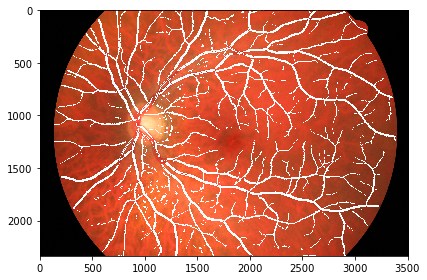

confusion matrix:
667660 , 140762
194763 , 5911184
accuracy: 0.9514742415396112
sensitivity: 0.8258805425879058
specificity: 0.968102736561585
geometric mean of sensitivity and specificity 0.8941684479740483


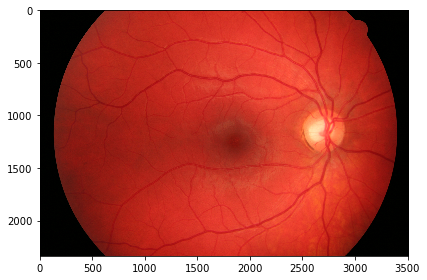

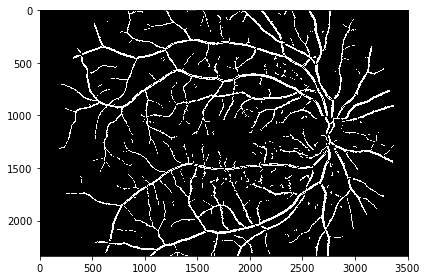

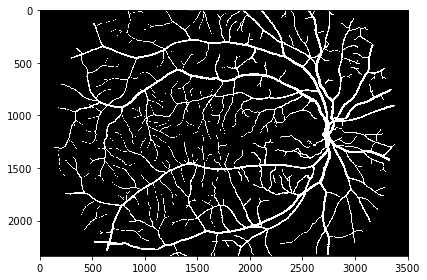

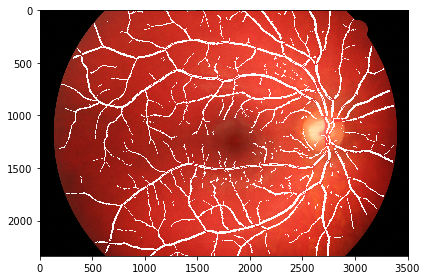

confusion matrix:
605787 , 258339
127257 , 5920689
accuracy: 0.9442141227695545
sensitivity: 0.7010401260927226
specificity: 0.978958641495807
geometric mean of sensitivity and specificity 0.828425789961769


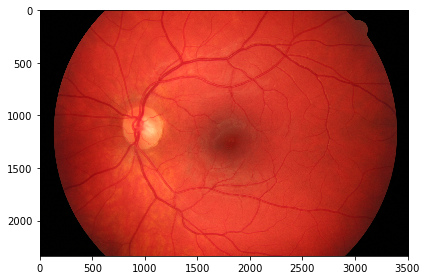

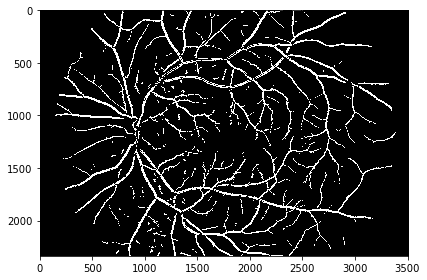

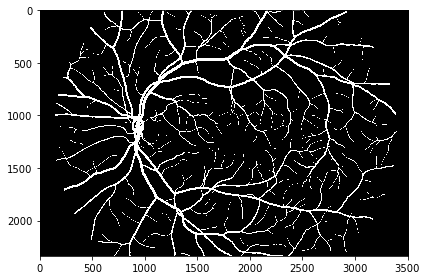

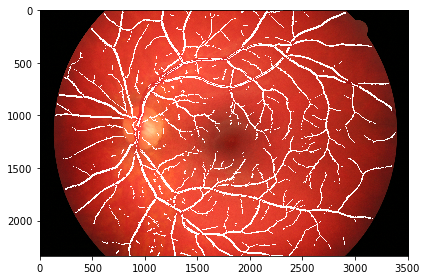

confusion matrix:
576031 , 195564
151573 , 5989844
accuracy: 0.9497849851844609
sensitivity: 0.7465457915097946
specificity: 0.9753195394483065
geometric mean of sensitivity and specificity 0.8532998872333245


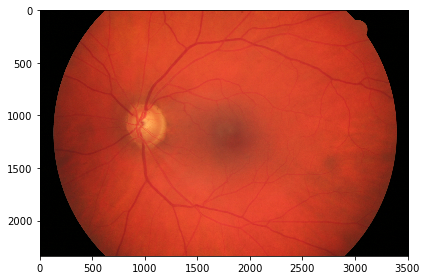

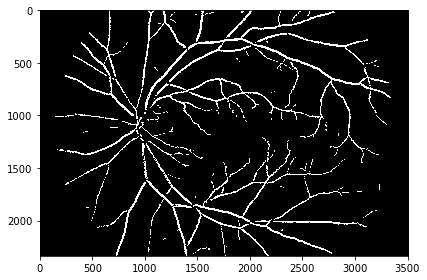

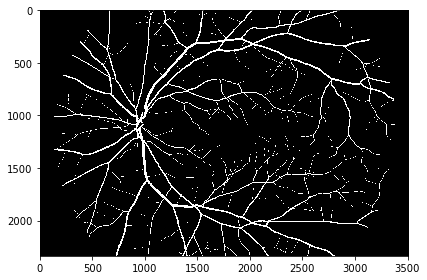

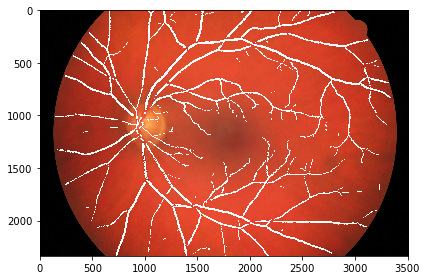

confusion matrix:
391192 , 135629
177184 , 6208840
accuracy: 0.9547490215678205
sensitivity: 0.7425520243118631
specificity: 0.9722544105690802
geometric mean of sensitivity and specificity 0.8496761034148294


In [15]:

if __name__ == '__main__':
    for i,[image,manual,mask] in enumerate(list_image()): 
        #my imshow inverts r and b channel, for visualisation purposes I swap them too
        plt.figure(0)
        b, g, r = cv2.split(image)
        new_image=image.copy()
        new_image[:,:,2] = b
        new_image[:,:,0] = r
        io.imshow(new_image)
        plt.figure(1)
        prepared_image = prepare_image(image)
        io.imshow(prepared_image)
        plt.figure(2)
        io.imshow(manual)
        plt.figure(3)
        new_image=image.copy()
        new_image[:,:,2] = cv2.add(b,prepared_image)
        new_image[:,:,1] = cv2.add(g,prepared_image)
        new_image[:,:,0] = cv2.add(r,prepared_image)
        io.imshow(new_image)
        plt.show()
        show_statistic(prepared_image, manual, mask)

Preparing train model for knn...
Preparing done!
knn processing...
Processing knn...
confusion matrix:
24485 , 157503
1656 , 1532848
accuracy: 0.9072765850350599
sensitivity: 0.13454183792337956
specificity: 0.9989208239274711
geometric mean of sensitivity and specificity 0.36660147789000874
result


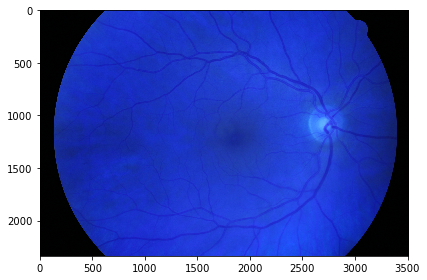

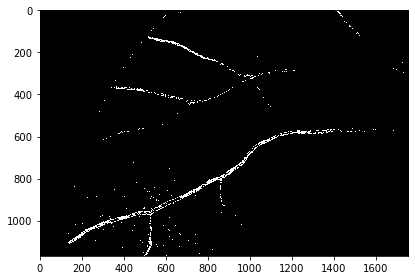

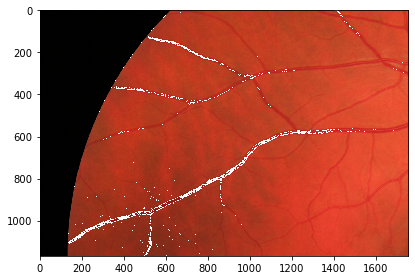

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
X_train=[]
y_train =[] 
for i,[image,manual,mask] in enumerate(list_image()): 
    if i == 0:
        print("Preparing train model for knn...")
        x,y,z = image.shape
        plt.figure(0)
        io.imshow(image)
        plt.figure(1)
        io.imshow(manual)
        prepare_test(image,manual,knn)
        print("Preparing done!")
    elif i == 6:
        test_knn(image[0:x,0:y//2,:], manual[0:x//2,0:y//2,:])
    else :
        print("knn processing...")
#         plt.figure(0)
#         x,y,z = image.shape
#         io.imshow(image)     
#         io.imshow(manual[0:x//4,0:y//4,:])
        prepared_image, new_image = process_knn(image,knn,manual,mask)
        print("result")
        plt.figure(1)
        io.imshow(prepared_image, cmap='gray')
        plt.figure(2)
        io.imshow(new_image)
    

